Importowanie bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from fancyimpute import IterativeImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
from sklearn.neighbors import NearestNeighbors

Uploadowanie danych

In [2]:
excel_file='/Users/a123456/Downloads/doi_10-4/geneticdata_with_coordinates.xlsx'
sheet_raw='allrawdata'

df=pd.read_excel(excel_file,sheet_raw)
microsatellites = df.drop(columns=['Sample','Longitude','Latitude','sex','age'])

coordinates = df[['Longitude','Latitude']]
scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(coordinates)

In [3]:
microsatellites.describe()

,DGN14,DGN14.1,REN69B24,REN69B24.1,V374,V374.1,V402,V402.1,VV-C01.424,VV-C01.424.1,...,REN161A12,REN161A12.1,REN162B09,REN162B09.1,VV-C08.618,VV-C08.618.1,VV-CPH2,VV-CPH2.1,V502,V502.1
count,357.000000,357.000000,352.000000,352.000000,364.000000,364.00000,365.000000,365.000000,367.000000,367.000000,...,357.000000,357.000000,345.000000,345.000000,335.000000,335.000000,360.000000,360.000000,357.000000,357.000000
mean,230.515406,242.549020,242.355114,260.860795,107.420330,112.42033,80.619178,84.098630,174.419619,177.831063,...,293.114846,300.450980,193.028986,194.918841,184.134328,188.316418,91.577778,92.766667,86.969188,88.565826
std,9.865267,12.244741,15.875819,14.581354,4.725142,3.16780,2.650972,3.261686,3.358937,2.234556,...,4.576531,6.617646,2.779551,1.222045,3.344025,2.883185,0.907754,1.112602,2.008872,3.390214
min,213.000000,213.000000,224.000000,224.000000,99.000000,99.00000,75.000000,75.000000,169.000000,169.000000,...,288.000000,288.000000,184.000000,186.000000,176.000000,178.000000,91.000000,91.000000,82.000000,82.000000
25%,225.000000,233.000000,228.000000,260.000000,101.000000,111.00000,79.000000,81.000000,169.000000,176.000000,...,290.000000,296.000000,193.000000,195.000000,182.000000,187.000000,91.000000,93.000000,86.000000,86.000000
50%,233.000000,241.000000,234.000000,262.000000,109.000000,113.00000,81.000000,83.000000,176.000000,178.000000,...,292.000000,298.000000,193.000000,195.000000,184.000000,188.000000,91.000000,93.000000,86.000000,88.000000
75%,237.000000,249.000000,260.000000,268.000000,111.000000,115.00000,81.000000,88.000000,176.000000,178.000000,...,296.000000,306.000000,195.000000,195.000000,186.000000,190.000000,93.000000,93.000000,88.000000,88.000000
max,266.000000,274.000000,277.000000,281.000000,115.000000,117.00000,88.000000,94.000000,180.000000,182.000000,...,312.000000,312.000000,197.000000,197.000000,190.000000,196.000000,93.000000,95.000000,97.000000,97.000000


# Exploratory data analysis

## Missing values

Cel ustalenie jakie wystepuja w danych, rodzaje missing values : 
- Missing Completely at Random **MCAR**
- Missing at Random **MAR**
- Missing Not at Random **MNAR**

Liczba missing values łacznie, pamiętamy ze mamy do kazdej mikrosatelity podtyp.

In [4]:
missing_all=microsatellites.isna().sum().sum()
missing_microsat=missing_all/2
missing_microsat

270.0

### Wizualizacja missing values

<Axes: >

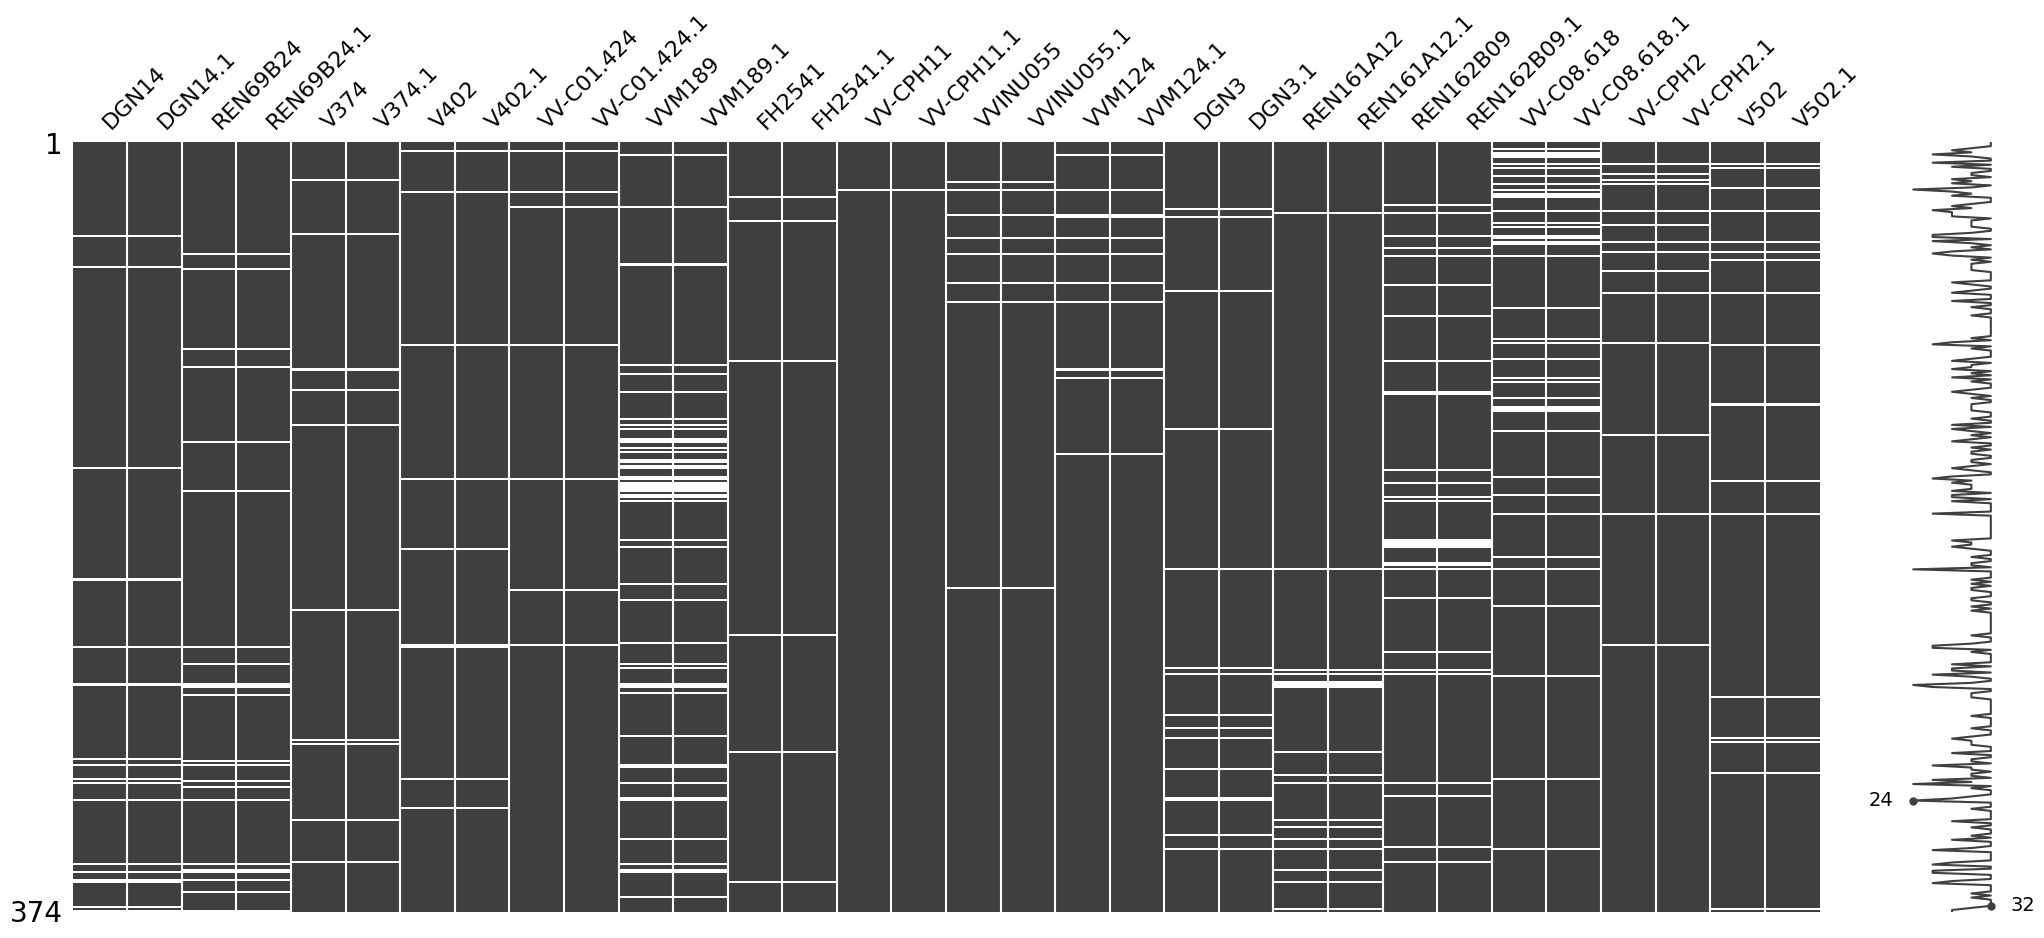

In [5]:
msno.matrix(microsatellites)

Widac ze pomiedzy tymi samymi podtypami lokus mikrosatelit (czyli te z oryginalna nazwa i te co maja ".1" na koncu) wystepuje wspolne NaN.

<Axes: >

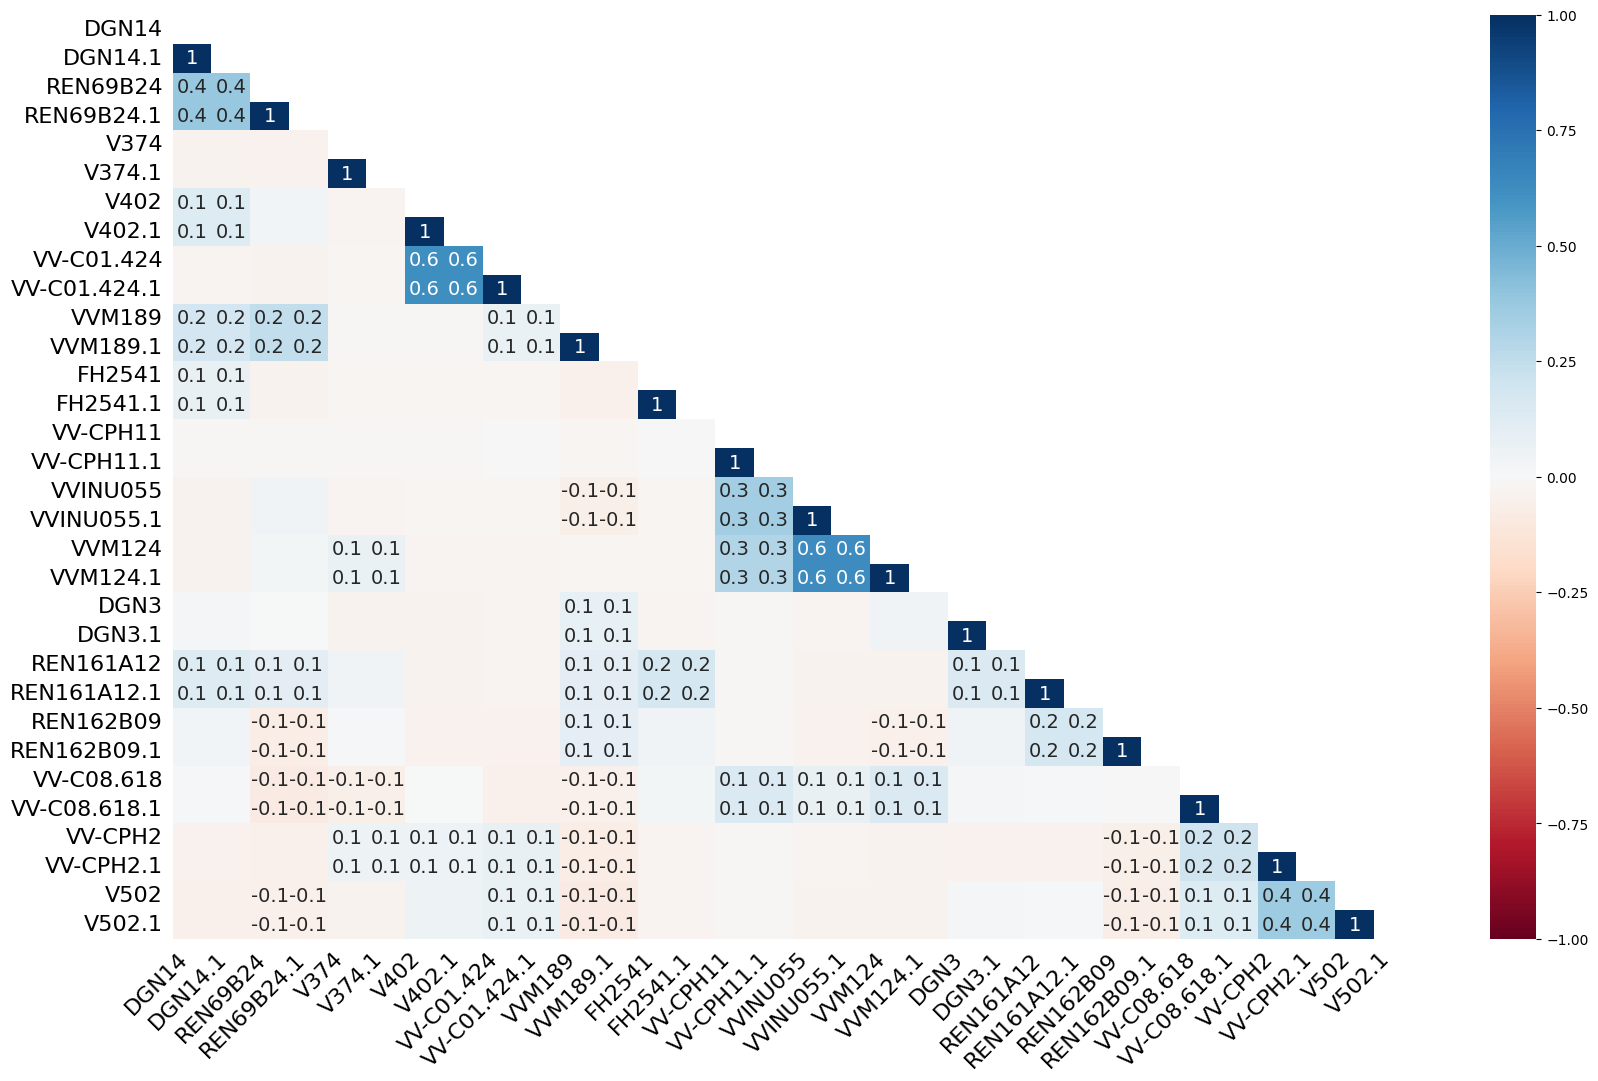

In [6]:
msno.heatmap(microsatellites)

Dla podtypów lokus odpowiadających mikrosatelit korelacja wyniosła wartość równą 1, co świadczy o doskonałej korelacji dodatniej między dwiema zmiennymi. Oznacza to, że kiedy w jednej kolumnie brakuje danych to jednocześnie w drugiej kolumnie również brakuje danych, i odwrotnie.

Wysokie wartości korelacji równe 0,6 zauważalne są również między dwoma parami markerów: „VV-C01.424.1” oraz „V402.1”, „VVM124.1” oraz „VVINU055.1”. Wymienione powyżej markery są przykładami braków nielosowych. Pozostałe korelacje uzyskały niskie wartości bliskie zeru co świadczy o znikomej zależności, zostały uznane jako braki całkowicie losowe. 

Wizualizacja mikrosatelit o korelacji 0.6

<Axes: >

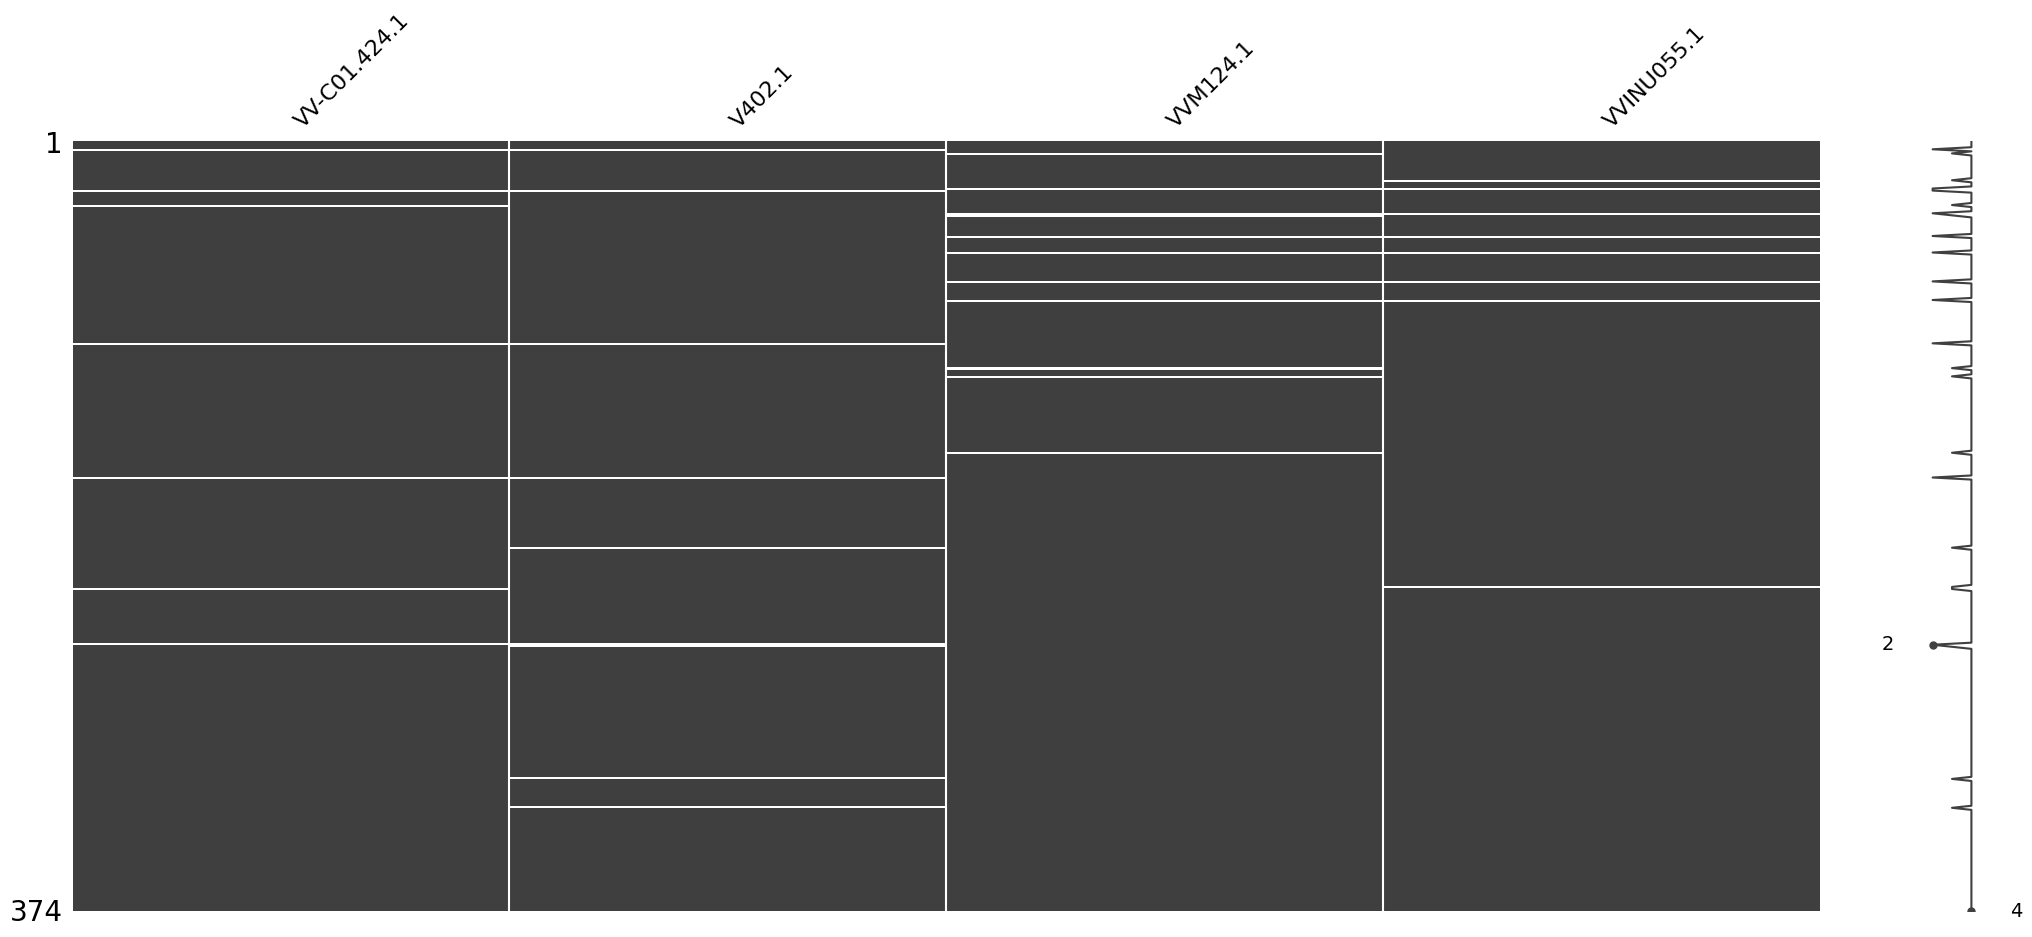

In [7]:
msno.matrix(microsatellites[['VV-C01.424.1','V402.1','VVM124.1','VVINU055.1']])

### Usunięcie poszczegolnych missing values

Wyliczenie procentowej sumy missing values w poszczegolnych mikrosatelitach.

In [8]:
precent_nan=round((microsatellites.isna().sum() * 100/ microsatellites.shape[0]),2)
print(precent_nan.sort_values())

VV-CPH11.1       0.27
VV-CPH11         0.27
FH2541.1         1.60
FH2541           1.60
VV-C01.424       1.87
VV-C01.424.1     1.87
VVINU055         2.14
VVINU055.1       2.14
V402             2.41
V402.1           2.41
V374             2.67
V374.1           2.67
VVM124           2.94
VVM124.1         2.94
VV-CPH2          3.74
VV-CPH2.1        3.74
DGN3.1           4.01
DGN3             4.01
REN161A12        4.55
REN161A12.1      4.55
DGN14            4.55
DGN14.1          4.55
V502             4.55
V502.1           4.55
REN69B24.1       5.88
REN69B24         5.88
REN162B09        7.75
REN162B09.1      7.75
VV-C08.618      10.43
VV-C08.618.1    10.43
VVM189.1        12.83
VVM189          12.83
dtype: float64


Najwięcej missing values wykryto u „REN162B09.1”, „VV-C08.618.1”, „VVM189.1” 

Wyznaczenie missing values ponizej 3%.

In [9]:
precent_nan[precent_nan<=3].sort_values()

VV-CPH11        0.27
VV-CPH11.1      0.27
FH2541          1.60
FH2541.1        1.60
VV-C01.424      1.87
VV-C01.424.1    1.87
VVINU055        2.14
VVINU055.1      2.14
V402            2.41
V402.1          2.41
V374            2.67
V374.1          2.67
VVM124          2.94
VVM124.1        2.94
dtype: float64

Wyznaczenie missing values powyzej 3%.

In [10]:
precent_nan[precent_nan>3].sort_values()

VV-CPH2.1        3.74
VV-CPH2          3.74
DGN3.1           4.01
DGN3             4.01
DGN14            4.55
REN161A12.1      4.55
V502             4.55
REN161A12        4.55
DGN14.1          4.55
V502.1           4.55
REN69B24.1       5.88
REN69B24         5.88
REN162B09        7.75
REN162B09.1      7.75
VV-C08.618      10.43
VV-C08.618.1    10.43
VVM189          12.83
VVM189.1        12.83
dtype: float64

Podjęto decyzję o usunięciu obserwacji dla wartości brakujących mikrosatelit, których braki stanowią nie więcej niż 3% danych z pominięciem mikrosatelit, które uzyskały wysokie wartości korelacji oraz te które miały z nimi wspólne braki. Do mikrosatelit, które spełniły warunki należą: „VV-CPH11.1”, „FH2541.1”, „V374.1”. 

In [11]:
micro_podropie = microsatellites.dropna(subset=['VV-CPH11.1','FH2541.1','V374.1'],how='any')
micro_podropie.describe()

,DGN14,DGN14.1,REN69B24,REN69B24.1,V374,V374.1,V402,V402.1,VV-C01.424,VV-C01.424.1,...,REN161A12,REN161A12.1,REN162B09,REN162B09.1,VV-C08.618,VV-C08.618.1,VV-CPH2,VV-CPH2.1,V502,V502.1
count,341.000000,341.000000,335.000000,335.000000,357.000000,357.000000,348.000000,348.000000,350.000000,350.000000,...,343.000000,343.000000,330.000000,330.000000,320.000000,320.000000,344.000000,344.000000,340.000000,340.000000
mean,230.656891,242.818182,242.447761,261.083582,107.481793,112.445378,80.600575,84.109195,174.425714,177.862857,...,293.148688,300.457726,192.996970,194.930303,184.121875,188.268750,91.569767,92.755814,86.967647,88.576471
std,9.931953,12.265773,15.806733,14.512194,4.705105,3.118531,2.648190,3.269742,3.348681,2.258012,...,4.611014,6.654185,2.792193,1.137102,3.343570,2.873993,0.904033,1.116388,2.037006,3.395734
min,213.000000,213.000000,224.000000,224.000000,99.000000,99.000000,75.000000,75.000000,169.000000,169.000000,...,288.000000,288.000000,184.000000,186.000000,176.000000,178.000000,91.000000,91.000000,82.000000,82.000000
25%,225.000000,233.000000,228.000000,260.000000,101.000000,111.000000,79.000000,81.000000,169.000000,176.000000,...,290.000000,296.000000,193.000000,195.000000,182.000000,186.000000,91.000000,93.000000,86.000000,86.000000
50%,233.000000,241.000000,234.000000,262.000000,110.000000,113.000000,81.000000,83.000000,176.000000,178.000000,...,292.000000,298.000000,193.000000,195.000000,184.000000,188.000000,91.000000,93.000000,86.000000,88.000000
75%,237.000000,249.000000,260.000000,268.000000,111.000000,115.000000,81.000000,88.000000,176.000000,180.000000,...,296.000000,305.000000,195.000000,195.000000,186.000000,190.000000,93.000000,93.000000,88.000000,88.000000
max,266.000000,274.000000,277.000000,281.000000,115.000000,117.000000,88.000000,94.000000,180.000000,182.000000,...,312.000000,312.000000,195.000000,197.000000,190.000000,196.000000,93.000000,95.000000,97.000000,97.000000


Szybkie porównanie danych przed i po usunieciu missing values

In [12]:
microsatellites.describe()

,DGN14,DGN14.1,REN69B24,REN69B24.1,V374,V374.1,V402,V402.1,VV-C01.424,VV-C01.424.1,...,REN161A12,REN161A12.1,REN162B09,REN162B09.1,VV-C08.618,VV-C08.618.1,VV-CPH2,VV-CPH2.1,V502,V502.1
count,357.000000,357.000000,352.000000,352.000000,364.000000,364.00000,365.000000,365.000000,367.000000,367.000000,...,357.000000,357.000000,345.000000,345.000000,335.000000,335.000000,360.000000,360.000000,357.000000,357.000000
mean,230.515406,242.549020,242.355114,260.860795,107.420330,112.42033,80.619178,84.098630,174.419619,177.831063,...,293.114846,300.450980,193.028986,194.918841,184.134328,188.316418,91.577778,92.766667,86.969188,88.565826
std,9.865267,12.244741,15.875819,14.581354,4.725142,3.16780,2.650972,3.261686,3.358937,2.234556,...,4.576531,6.617646,2.779551,1.222045,3.344025,2.883185,0.907754,1.112602,2.008872,3.390214
min,213.000000,213.000000,224.000000,224.000000,99.000000,99.00000,75.000000,75.000000,169.000000,169.000000,...,288.000000,288.000000,184.000000,186.000000,176.000000,178.000000,91.000000,91.000000,82.000000,82.000000
25%,225.000000,233.000000,228.000000,260.000000,101.000000,111.00000,79.000000,81.000000,169.000000,176.000000,...,290.000000,296.000000,193.000000,195.000000,182.000000,187.000000,91.000000,93.000000,86.000000,86.000000
50%,233.000000,241.000000,234.000000,262.000000,109.000000,113.00000,81.000000,83.000000,176.000000,178.000000,...,292.000000,298.000000,193.000000,195.000000,184.000000,188.000000,91.000000,93.000000,86.000000,88.000000
75%,237.000000,249.000000,260.000000,268.000000,111.000000,115.00000,81.000000,88.000000,176.000000,178.000000,...,296.000000,306.000000,195.000000,195.000000,186.000000,190.000000,93.000000,93.000000,88.000000,88.000000
max,266.000000,274.000000,277.000000,281.000000,115.000000,117.00000,88.000000,94.000000,180.000000,182.000000,...,312.000000,312.000000,197.000000,197.000000,190.000000,196.000000,93.000000,95.000000,97.000000,97.000000


Po usunięciu odpowiednich obserwacji obliczono różnice odchyleń standardowych po i przed zastosowaniem metody w celu sprawdzenia czy sposób ten jest właściwy i nie spowoduje usunięcie zbyt dużej ilości danych. 

In [13]:
std_podropie = micro_podropie.std()
std=microsatellites.std()
std_diff_con=round(abs(std_podropie-std),2).sort_values()
std_diff_con=std_diff_con[std_diff_con>=0.05] #wybranie wartości wylacznie równych lub powyzej 0.05
std_diff_con

V374.1         0.05
VVINU055       0.05
FH2541.1       0.06
REN69B24.1     0.07
REN69B24       0.07
DGN14          0.07
DGN3.1         0.08
REN162B09.1    0.08
DGN3           0.16
dtype: float64

Wartości różnic odchylenia standardowego były niewielkie, gdzie wyłącznie jedna mikrosatelita „DGN3” przekroczyła wartość 0,1.

Nastepnie wyliczono ile w procentach usunieto danych.

In [14]:
percent_podropie=micro_podropie.shape[0]*100/microsatellites.shape[0]
print(round(100-percent_podropie,3))

4.545


Zapisanie do pliku excel

In [15]:
std_diff_con_df = pd.DataFrame(std_diff_con, columns=['diff'])
sorted_df = std_diff_con_df.sort_values(by='diff')
sorted_df.to_excel('std_diff_con_df.xlsx')

Sprawdzenie czy usuniecie poszczegolnych danyc sie udalo

In [16]:
microsatellites=microsatellites.dropna(subset=['VV-CPH11.1','FH2541.1','V374.1'],how='any')
microsatellites.isna().sum()

DGN14           16
DGN14.1         16
REN69B24        22
REN69B24.1      22
V374             0
V374.1           0
V402             9
V402.1           9
VV-C01.424       7
VV-C01.424.1     7
VVM189          47
VVM189.1        47
FH2541           0
FH2541.1         0
VV-CPH11         0
VV-CPH11.1       0
VVINU055         7
VVINU055.1       7
VVM124           9
VVM124.1         9
DGN3            15
DGN3.1          15
REN161A12       14
REN161A12.1     14
REN162B09       27
REN162B09.1     27
VV-C08.618      37
VV-C08.618.1    37
VV-CPH2         13
VV-CPH2.1       13
V502            17
V502.1          17
dtype: int64

### Imputacja missing values

Pozostałe brakujące wartości analizowanych danych zastąpiono metodą MICE oraz wartościami średnich wartości dla podanych zmiennych w celu zidentyfikowania lepszej metody. 

Zauważalne są niewielkie różnice w wyestymowanych wartościach odchylenia standardowego między dwiema zastosowanymi metodami. Ze względu na mniejsze wartości zdecydowano się na imputacje MICE.

#### MICE

In [17]:
from fancyimpute import IterativeImputer
microsatellites_MICE= microsatellites.copy(deep=True)
MICE_imputer= IterativeImputer()
microsatellites.iloc[:,:]=MICE_imputer.fit_transform(microsatellites_MICE)

Sprawdzenie czy imputacja sie powiodła

In [18]:
microsatellites.isna().sum()

DGN14           0
DGN14.1         0
REN69B24        0
REN69B24.1      0
V374            0
V374.1          0
V402            0
V402.1          0
VV-C01.424      0
VV-C01.424.1    0
VVM189          0
VVM189.1        0
FH2541          0
FH2541.1        0
VV-CPH11        0
VV-CPH11.1      0
VVINU055        0
VVINU055.1      0
VVM124          0
VVM124.1        0
DGN3            0
DGN3.1          0
REN161A12       0
REN161A12.1     0
REN162B09       0
REN162B09.1     0
VV-C08.618      0
VV-C08.618.1    0
VV-CPH2         0
VV-CPH2.1       0
V502            0
V502.1          0
dtype: int64

In [19]:
microsatellites_MICE.describe()

,DGN14,DGN14.1,REN69B24,REN69B24.1,V374,V374.1,V402,V402.1,VV-C01.424,VV-C01.424.1,...,REN161A12,REN161A12.1,REN162B09,REN162B09.1,VV-C08.618,VV-C08.618.1,VV-CPH2,VV-CPH2.1,V502,V502.1
count,341.000000,341.000000,335.000000,335.000000,357.000000,357.000000,348.000000,348.000000,350.000000,350.000000,...,343.000000,343.000000,330.000000,330.000000,320.000000,320.000000,344.000000,344.000000,340.000000,340.000000
mean,230.656891,242.818182,242.447761,261.083582,107.481793,112.445378,80.600575,84.109195,174.425714,177.862857,...,293.148688,300.457726,192.996970,194.930303,184.121875,188.268750,91.569767,92.755814,86.967647,88.576471
std,9.931953,12.265773,15.806733,14.512194,4.705105,3.118531,2.648190,3.269742,3.348681,2.258012,...,4.611014,6.654185,2.792193,1.137102,3.343570,2.873993,0.904033,1.116388,2.037006,3.395734
min,213.000000,213.000000,224.000000,224.000000,99.000000,99.000000,75.000000,75.000000,169.000000,169.000000,...,288.000000,288.000000,184.000000,186.000000,176.000000,178.000000,91.000000,91.000000,82.000000,82.000000
25%,225.000000,233.000000,228.000000,260.000000,101.000000,111.000000,79.000000,81.000000,169.000000,176.000000,...,290.000000,296.000000,193.000000,195.000000,182.000000,186.000000,91.000000,93.000000,86.000000,86.000000
50%,233.000000,241.000000,234.000000,262.000000,110.000000,113.000000,81.000000,83.000000,176.000000,178.000000,...,292.000000,298.000000,193.000000,195.000000,184.000000,188.000000,91.000000,93.000000,86.000000,88.000000
75%,237.000000,249.000000,260.000000,268.000000,111.000000,115.000000,81.000000,88.000000,176.000000,180.000000,...,296.000000,305.000000,195.000000,195.000000,186.000000,190.000000,93.000000,93.000000,88.000000,88.000000
max,266.000000,274.000000,277.000000,281.000000,115.000000,117.000000,88.000000,94.000000,180.000000,182.000000,...,312.000000,312.000000,195.000000,197.000000,190.000000,196.000000,93.000000,95.000000,97.000000,97.000000


Porównanie danych przed i po imputacji.

In [20]:
microsatellites.describe()

,DGN14,DGN14.1,REN69B24,REN69B24.1,V374,V374.1,V402,V402.1,VV-C01.424,VV-C01.424.1,...,REN161A12,REN161A12.1,REN162B09,REN162B09.1,VV-C08.618,VV-C08.618.1,VV-CPH2,VV-CPH2.1,V502,V502.1
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,...,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,230.653739,242.821090,242.390787,261.097452,107.481793,112.445378,80.597247,84.108059,174.431362,177.871369,...,293.121228,300.427747,192.993684,194.943791,184.109173,188.255006,91.569453,92.755698,86.957391,88.556772
std,9.714279,11.993909,15.325873,14.061702,4.705105,3.118531,2.616772,3.229263,3.317461,2.236983,...,4.525716,6.534379,2.684341,1.097858,3.168587,2.727840,0.887428,1.095829,1.991439,3.322318
min,213.000000,213.000000,224.000000,224.000000,99.000000,99.000000,75.000000,75.000000,169.000000,169.000000,...,288.000000,288.000000,184.000000,186.000000,176.000000,178.000000,91.000000,91.000000,82.000000,82.000000
25%,225.000000,233.000000,228.000000,260.000000,101.000000,111.000000,79.000000,81.000000,169.000000,176.000000,...,290.000000,296.000000,193.000000,195.000000,182.000000,187.805104,91.000000,92.795958,86.000000,86.000000
50%,232.000000,241.000000,239.867954,262.000000,110.000000,113.000000,81.000000,83.000000,176.000000,178.000000,...,292.000000,299.801223,193.000000,195.000000,184.000000,188.000000,91.000000,93.000000,86.000000,88.000000
75%,237.000000,249.000000,260.000000,268.000000,111.000000,115.000000,81.000000,88.000000,176.000000,180.000000,...,296.000000,304.000000,195.000000,195.000000,186.000000,190.000000,93.000000,93.000000,88.000000,88.000000
max,266.000000,274.000000,277.000000,281.000000,115.000000,117.000000,88.000000,94.000000,180.000000,182.000000,...,312.000000,312.000000,195.000000,197.000000,190.000000,196.000000,93.000000,95.000000,97.000000,97.000000


Porównano różnice odchylenia standardowego po i przed imputacją.

In [21]:
MICE_std_diff=round(abs(microsatellites_MICE.std()-microsatellites.std()),2).sort_values()
MICE_std_diff_cond=MICE_std_diff[MICE_std_diff>0.1]
MICE_std_diff_cond

REN162B09       0.11
REN161A12.1     0.12
VV-C08.618.1    0.15
VV-C08.618      0.17
DGN14           0.22
DGN3.1          0.25
DGN3            0.26
DGN14.1         0.27
VVM189.1        0.37
VVM189          0.38
REN69B24.1      0.45
REN69B24        0.48
dtype: float64

Zapisanie do pliku excel.

In [22]:
MICE_std_diff_df = pd.DataFrame(MICE_std_diff_cond, columns=['mice_std'])
MICE_std_diff_df.to_excel('MICE_std_diff_df.xlsx')

#### MEAN

In [23]:
from sklearn.impute import SimpleImputer
mean_microsatellites=microsatellites.copy(deep=True)
mean_imputer = SimpleImputer(strategy='mean')
mean_microsatellites.iloc[:,:] = mean_imputer.fit_transform(mean_microsatellites)

In [24]:
mean_std_diff=round(abs(mean_microsatellites.std()-microsatellites.std()),2).sort_values()
mean_std_diff_cond=mean_std_diff[mean_std_diff>0.1]
mean_std_diff_cond

Series([], dtype: float64)

In [25]:
meanimp_std_diff_df = pd.DataFrame(mean_std_diff_cond, columns=['mean_imputation_std'])
meanimp_std_diff_df.to_excel('meanimp_std_diff_df.xlsx')

### Duplikaty wsrod NaN

ta czesc kodu nie zostala zawarta w pracy magisterskiej.

In [26]:
col_names_dot = [col for col in microsatellites.columns if col.endswith('.1')]
wyniki_df = pd.DataFrame(index=col_names_dot, columns=col_names_dot, dtype=int)

for kolumna in col_names_dot:
    for porownywana_kolumna in col_names_dot:
        if kolumna == porownywana_kolumna:
            wyniki_df.loc[kolumna, porownywana_kolumna] = np.nan
        else:
            maska_nan = microsatellites[kolumna].isnull() & microsatellites[porownywana_kolumna].isnull()
            liczba_wspolnych_nan = np.sum(maska_nan)
            if liczba_wspolnych_nan > 3: #jest duzo malych wartosci wiec dajemy warunek
                wyniki_df.loc[kolumna, porownywana_kolumna] = liczba_wspolnych_nan


In [27]:
results = []
for kolumna in col_names_dot:
    for porownywana_kolumna in col_names_dot:
        if kolumna != porownywana_kolumna:
            value = wyniki_df.loc[kolumna, porownywana_kolumna]
            if pd.notnull(value):
                results.append({'Kolumna': kolumna, 'Porównywana Kolumna': porownywana_kolumna, 'Liczba wspólnych NaN': value})

wyniki_rzeczywiste_df = pd.DataFrame(results)

In [28]:
wyniki_rzeczywiste_df

""


In [29]:
#pd.concat([wyniki_rzeczywiste_df['Kolumna'], wyniki_rzeczywiste_df['Porównywana Kolumna']]).value_counts()


In [30]:
#plt.figure(figsize=(10, 8))
#sns.heatmap(wyniki_df, annot=True, cmap='coolwarm', linewidths=.5)
#plt.title('Liczba wspólnych NaN między mikrosatelitami')
#plt.xlabel('Mikrosatelity')
#plt.ylabel('Mikrosatelity')
#plt.show()

## Usuniecie wartości odstajacych

In [31]:
import plotly.express as px
fig = px.scatter_mapbox(coordinates,
                     lat='Latitude',
                     lon='Longitude',
                     zoom=3)


fig.update_layout(mapbox_style='carto-positron',
                    margin={'r': 10, 't': 10, 'l': 10, 'b': 10})
fig.show()

In [32]:
def outliers(data,feature):
        final_data = data.copy()
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[feature] < (lower_bound)) | (data[feature] > (upper_bound))]
        final_data = final_data[(final_data[feature] >= lower_bound) & (final_data[feature] <= upper_bound)]
        percent = round(len(outliers)*100/len(data),3)
        print(f'Number of outliers: {len(outliers)}\nNumber of observations: {len(data)}\nPercent of outliers: {percent}')
        return final_data, outliers

In [33]:
coord_cleaned,coord_outliers1=outliers(coordinates,'Longitude')

Number of outliers: 29
Number of observations: 374
Percent of outliers: 7.754


In [34]:
coord_cleaned,coord_outliers1=outliers(coord_cleaned,'Latitude')

Number of outliers: 39
Number of observations: 345
Percent of outliers: 11.304


In [35]:
fig = px.scatter_mapbox(coord_cleaned,
                     lat='Latitude',
                     lon='Longitude',
                     zoom=3)


fig.update_layout(mapbox_style='carto-positron',
                    margin={'r': 10, 't': 10, 'l': 10, 'b': 10})
fig.show()

In [36]:
(26+37)*100/357

17.647058823529413

Usuniecie 17,65% danych

## Analiza korelacji oraz rozkładu danych

### Rozklad danych

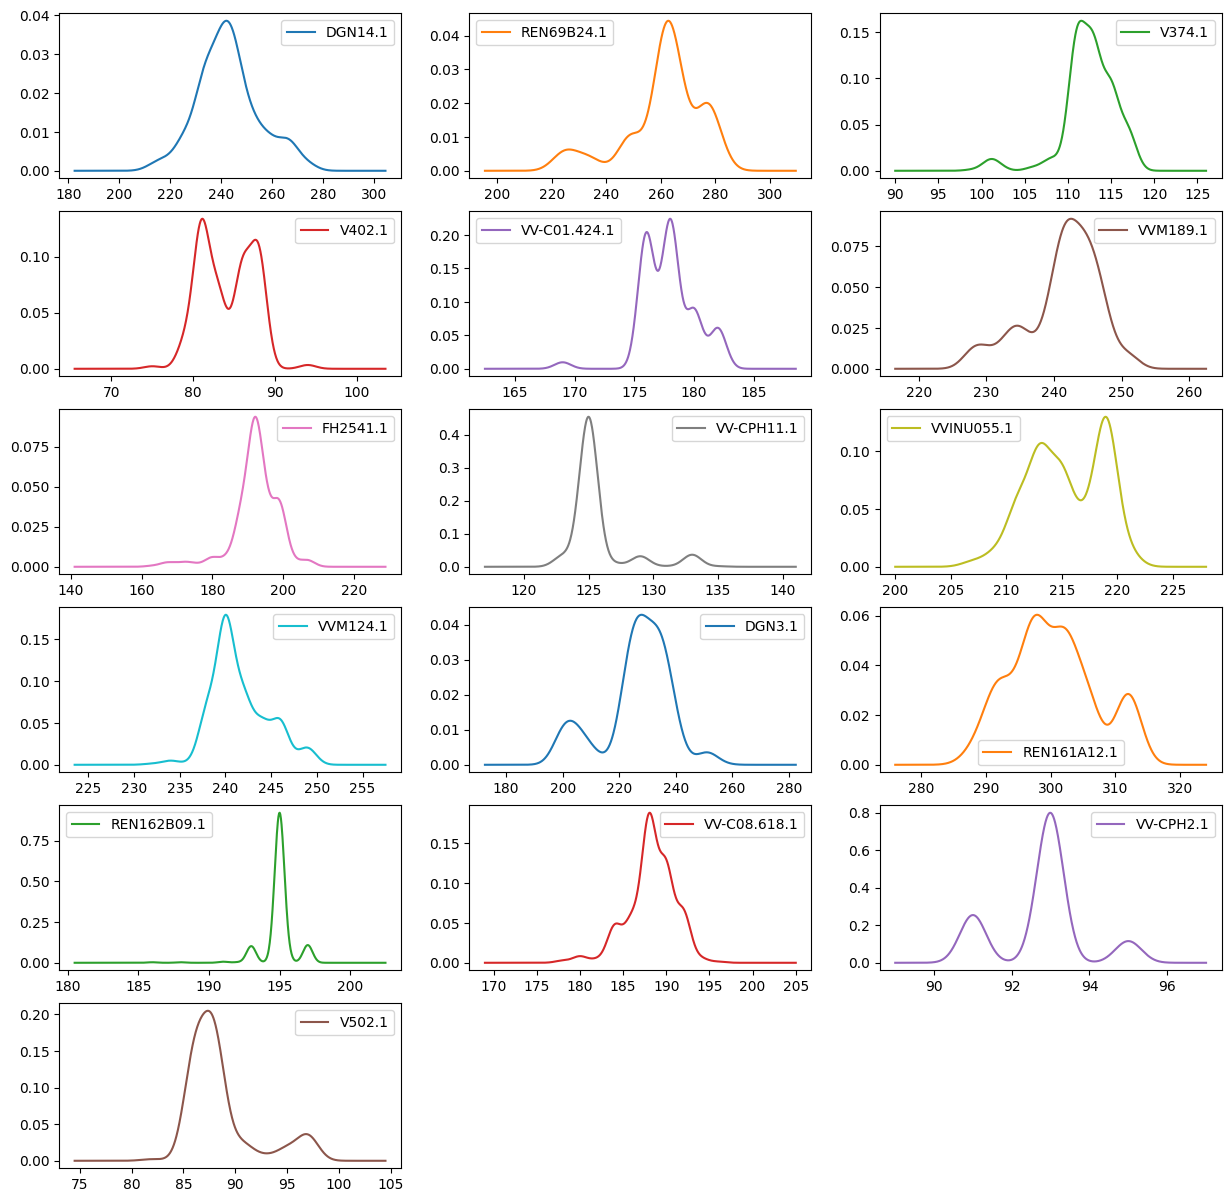

In [37]:
col_names_dot = [col for col in microsatellites.columns if col.endswith('.1')]
MICRO_DOT=microsatellites[col_names_dot]
axes=MICRO_DOT.plot(kind='density', subplots=True,layout=(-1, 3), sharex=False, figsize=(15,15))
axes = axes.flatten()

for ax in axes:
    ax.set_ylabel('') 
plt.show()

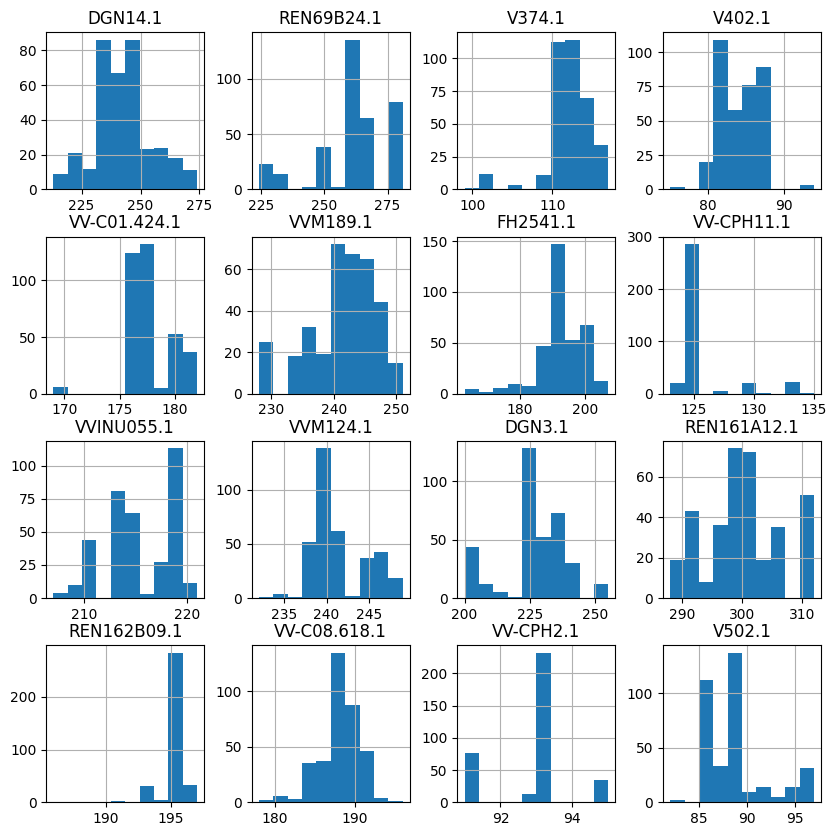

In [38]:
MICRO_DOT.hist(figsize=(10, 10))
plt.show()

Wstępna wizualizacja danych dotyczących mikrosatelit wykazała obecność rozkładów kształtów niestandardowych. W celu uzyskania pewności, że żadna zmienna nie wykazuję rozkładu normalnego wykonano test Shapiro-Wilka przy poziomie istotności 5%, gdzie hipoteza zerowa zakłada, że dane pochodzą z rozkładu normalnego. 

In [39]:
results_list = []
col_names_dot = [col for col in microsatellites.columns if col.endswith('.1')]

for col in col_names_dot:
    stat, p = shapiro(microsatellites[col])
    results_list.append({'mikrosatelita': col, 'stat': round(stat,3), 'p-value': p})

shapiro_results = pd.DataFrame(results_list)
shapiro_results

,mikrosatelita,stat,p-value
0,DGN14.1,0.970,9.127413e-07
1,REN69B24.1,0.866,5.254763e-17
2,V374.1,0.824,1.914541e-19
3,V402.1,0.888,1.780305e-15
4,VV-C01.424.1,0.840,1.353815e-18
5,VVM189.1,0.921,8.460761e-13
6,FH2541.1,0.855,1.094825e-17
7,VV-CPH11.1,0.516,4.265926e-30
8,VVINU055.1,0.908,6.441845e-14
9,VVM124.1,0.904,2.892969e-14


Wartość p-value dla wszystkich mikrosatelit wyniosła poniżej 0,05 w wyniku czego odrzucono dla każdej hipotezę zerową co świadczy o braku rozkładu normalnego.

Wyniki zapisano do pliku excel.

In [40]:
shapiro_results.to_excel('shapiro_results.xlsx')

### Korelacja

Z powodu braku rozkładu normalnego wśród analizowanych danych zastosowano korelacje Spearmana.

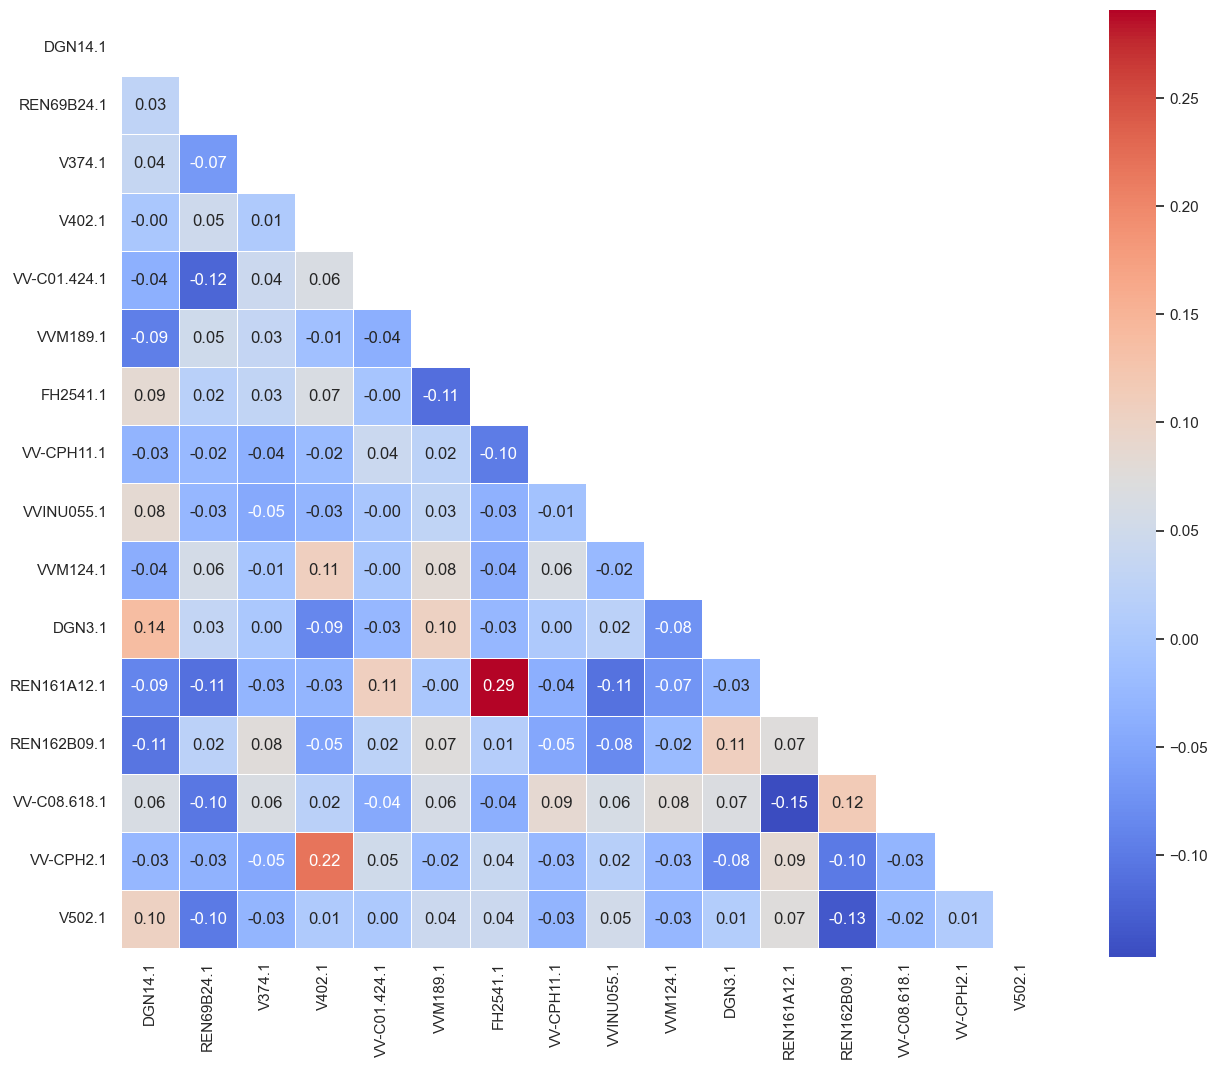

In [41]:
col_names_dot = [col for col in microsatellites.columns if col.endswith('.1')]

correlation_matrix = microsatellites[col_names_dot].corr(method='spearman')
correlation_df = pd.DataFrame(correlation_matrix, index=col_names_dot, columns=col_names_dot)

mask = np.triu(np.ones_like(correlation_df, dtype=bool))
sns.set(style="white")
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .82}, linewidths=.5, mask=mask)
plt.show()


Porównano wartości korelacji między mikrosatelitami, gdzie najwyższa wartość osiągnęła 0,28 natomiast najniższa -0,14. Wartości tak bliskie zeru świadczą o znikomej korelacji między zmiennymi.

Następnie wyliczono wartości korelacji między oryginalną mikrosatelitą, a jej konkretnym podtypem lokus.

In [42]:
results = []

for col in microsatellites.columns:
    if col.endswith('.1'):
        orig_col = col[:-2]
        if orig_col in microsatellites.columns:
            orgd = microsatellites[orig_col]
            col1 = microsatellites[col]
            spearman_correlation, p_value = stats.spearmanr(orgd, col1)
            results.append({
                'Original Column': orig_col,
                'Compared Column': col,
                'Spearman Correlation': round(spearman_correlation, 3),
                'P-value': p_value
            })

correlation_results_df = pd.DataFrame(results)
sorted_correlation_results_df = correlation_results_df.sort_values(by='Spearman Correlation', ascending=False)

print(sorted_correlation_results_df)

   Original Column Compared Column  Spearman Correlation       P-value
15            V502          V502.1                 0.557  1.839348e-30
5           VVM189        VVM189.1                 0.520  3.861584e-26
0            DGN14         DGN14.1                 0.500  6.002972e-24
8         VVINU055      VVINU055.1                 0.483  2.808485e-22
2             V374          V374.1                 0.465  1.398372e-20
10            DGN3          DGN3.1                 0.453  1.690197e-19
3             V402          V402.1                 0.444  1.185657e-18
1         REN69B24      REN69B24.1                 0.439  2.728390e-18
9           VVM124        VVM124.1                 0.435  6.696023e-18
6           FH2541        FH2541.1                 0.422  7.962384e-17
13      VV-C08.618    VV-C08.618.1                 0.378  1.351753e-13
11       REN161A12     REN161A12.1                 0.358  3.196721e-12
4       VV-C01.424    VV-C01.424.1                 0.327  2.489386e-10
7     

Największa wartość wyniosła 0,557 natomiast najmniejsza 0,265 (Tabela 5). Stwierdzono, że wyestymowane wartości są za niskie, aby stwierdzić pewną korelację pomiędzy podanymi mikrosatelitami.  

In [43]:
sorted_correlation_results_df.to_excel('sorted_correlation_results_df.xlsx')

In [44]:
microsatellites.to_excel('microsatellites.xlsx')

# Principal component analysis 

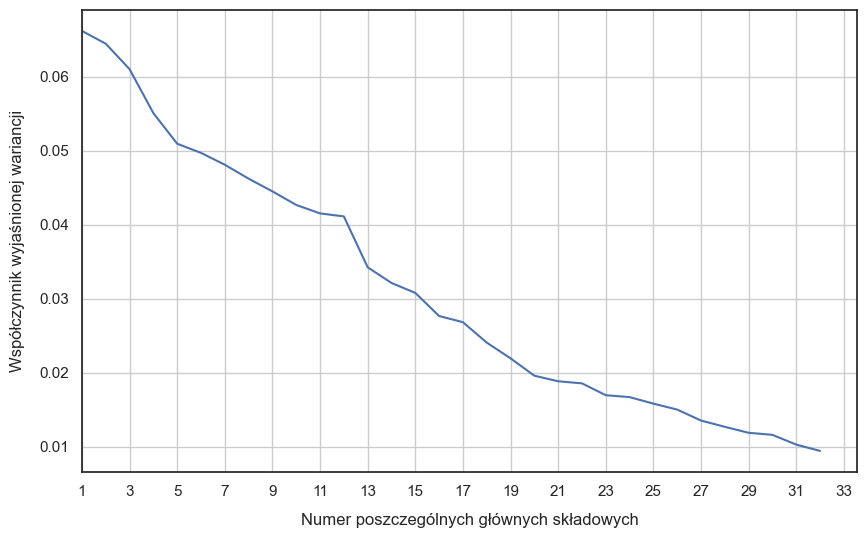

In [45]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer',PCA())]) #n_components=.9
after_pca=pipe.fit(microsatellites) #fit_transform
var= pipe['reducer'].explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(var)+1),var)
plt.xlabel('Numer poszczególnych głównych składowych',labelpad=10)
plt.ylabel('Współczynnik wyjaśnionej wariancji',labelpad=10)
plt.xlim(left=1)
plt.xticks(np.arange(1,34,2))
plt.grid(True)
plt.show()

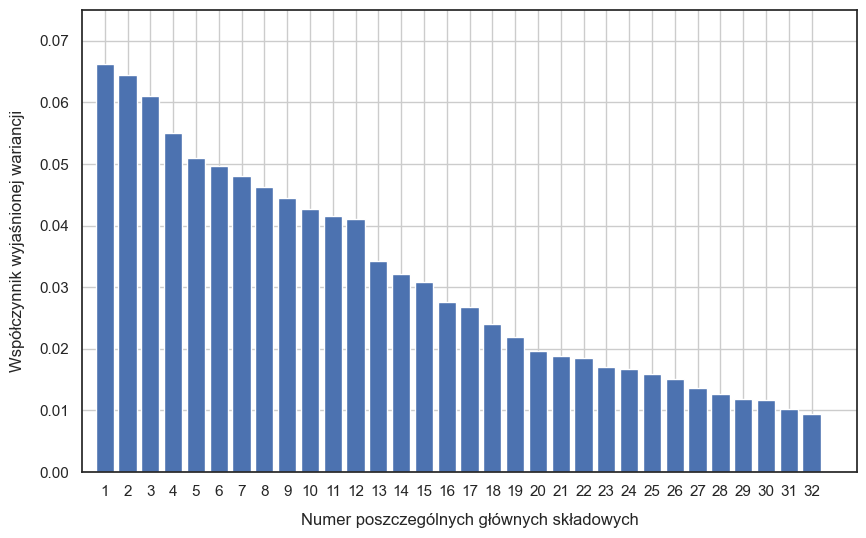

In [46]:
features=range(pipe['reducer'].n_components_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, len(var)+1),var)
#plt.xticks(np.arange(1, len(var)+1))
plt.ylabel('Współczynnik wyjaśnionej wariancji',labelpad=10)
plt.xlabel('Numer poszczególnych głównych składowych',labelpad=10)
plt.xticks(np.arange(1,33))
plt.yticks(np.arange(0,0.07,0.01))
plt.xlim(left=-0)
plt.ylim(top=0.075)
plt.grid(True)
plt.show()

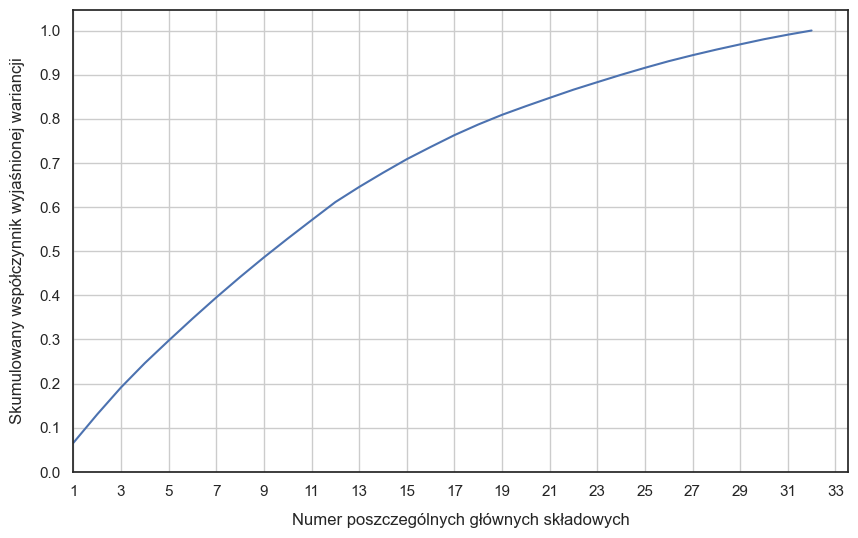

In [47]:
cumulative_var = np.cumsum(var)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_var)+1), cumulative_var)
#plt.plot(cumulative_var*100)
plt.xlabel('Numer poszczególnych głównych składowych',labelpad=10)
plt.ylabel('Skumulowany współczynnik wyjaśnionej wariancji',labelpad=10)
plt.xlim(left=1)
plt.xticks(np.arange(1,34,2))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.show()

In [48]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer',PCA(n_components=13))]) 
pca_ready=pipe.fit_transform(microsatellites)

In [49]:
principal_df = pd.DataFrame(data=pca_ready, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13'])

# DBSCAN

In [50]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

gdf = GeoDataFrame(coord_cleaned, geometry=[Point(xy) for xy in zip(coord_cleaned.Longitude, coord_cleaned.Latitude)])
gdf.crs = 'EPSG:4326'

In [51]:
gdf = gdf.reset_index(drop=True)
gdf[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13']] = principal_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13']]

In [52]:
gdf=gdf.dropna()
gdf.isna().sum()

Longitude    0
Latitude     0
geometry     0
PC1          0
PC2          0
PC3          0
PC4          0
PC5          0
PC6          0
PC7          0
PC8          0
PC9          0
PC10         0
PC11         0
PC12         0
PC13         0
dtype: int64

In [53]:
gdf

,Longitude,Latitude,geometry,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,13.356389,52.573250,POINT (13.35639 52.57325),-0.717211,0.428744,-1.231522,1.386955,-0.083496,0.532792,-1.220683,-0.447963,-0.824316,-0.051564,-0.919410,0.939840,0.599341
1,13.356389,52.573250,POINT (13.35639 52.57325),3.113094,0.336562,0.052321,0.664529,0.530362,-1.351089,-0.448037,0.741026,1.216790,-0.395249,-0.885882,0.962615,-2.522675
2,13.387306,52.589056,POINT (13.38731 52.58906),-1.789488,1.866810,1.419445,2.959233,-2.639910,0.148990,-0.948874,0.601777,-0.902570,0.251137,1.702760,-1.085916,-1.698692
3,13.632750,52.516000,POINT (13.63275 52.51600),-1.659007,-2.184777,0.899387,-1.647252,-0.324259,0.295543,-0.369500,-0.342611,0.014226,-0.471889,-0.885464,-0.872249,-0.319125
4,13.578528,52.412361,POINT (13.57853 52.41236),1.789680,-0.894133,-0.491243,-0.048383,0.249901,1.274806,-0.958584,0.044228,-1.109175,-0.751626,0.859185,0.345825,-0.124585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,12.748889,52.369083,POINT (12.74889 52.36908),-1.311979,-2.675413,-0.996148,0.507684,0.404485,1.486470,-0.937854,-0.441503,-2.190256,0.556392,0.801605,0.060026,-0.642940
302,13.700889,52.709028,POINT (13.70089 52.70903),-0.510348,-0.606067,0.172507,-0.507178,-1.061783,0.716893,1.591991,-2.148389,-0.655166,-0.243937,-1.039265,0.131295,0.456242
303,13.031289,52.401006,POINT (13.03129 52.40101),1.231000,1.463308,-0.793099,3.421239,-0.822975,1.207730,-0.504764,1.068332,-0.506578,-1.645109,-0.071021,-0.655159,-0.491311
304,12.754136,52.403600,POINT (12.75414 52.40360),-0.102948,-1.702702,-1.681905,2.223603,0.245450,0.115073,-0.401213,0.774257,0.015738,-1.766823,0.625827,1.060248,-0.280681


In [54]:
def najblizszychsasiadow(data, neighbors_count,line1,line2):
    neighbors_model = NearestNeighbors(n_neighbors=neighbors_count)
    neighbors_fit = neighbors_model.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    sorted_distances = np.sort(distances[:, neighbors_count-1], axis=0)
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    ax.set_xlabel("Sample number")
    ax.set_ylabel("Distance to furthest nearest neighbor")
    ax.plot(sorted_distances)
    #ax.set_yticks(range) 
    ax.axhline(y=line1, linestyle='dashed')
    ax.axhline(y=line2, linestyle='dashed')
    plt.show()

In [55]:
from sklearn.metrics import silhouette_score as sklearn_silhouette_score
from sklearn.cluster import DBSCAN

def evaluate_silhouette_score(data,eps_range, min_samples_range):
    output = []
    for ms in min_samples_range:
        for ep in eps_range:
            labels = DBSCAN(min_samples=ms, eps=ep).fit(data).labels_
            n_clusters = len(np.unique(labels))
            if n_clusters > 1:
                score = sklearn_silhouette_score(data, labels)
                output.append((ms, ep, score))
        
    if output:
        min_samples, eps, score = sorted(output, key=lambda x: x[-1], reverse=True)[0]
        print(f"Best silhouette score: {score}")
        print(f"min_samples: {min_samples}")
        print(f"eps: {eps}")
    else:
        print("DBSCAN failed to produce meaningful clusters for the given parameter range.")

In [56]:
from sklearn.cluster import DBSCAN

def dbscan(xy, epsilon, minpoints):
    
    dbsc = DBSCAN(eps=epsilon, min_samples=minpoints).fit(xy)
    labels = dbsc.labels_
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)
    print(f"Liczba clusters: {num_clusters}")
    
    for cluster_label in unique_labels:
        if cluster_label == -1:
            plt.scatter(xy[labels == cluster_label][:, 0], xy[labels == cluster_label][:, 1], color='black', marker='x', label='Noise')
        else:
            plt.scatter(xy[labels == cluster_label][:, 0], xy[labels == cluster_label][:, 1], label=f'Cluster {cluster_label + 1}')
    
    plt.title("DBSCAN Clustering")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()

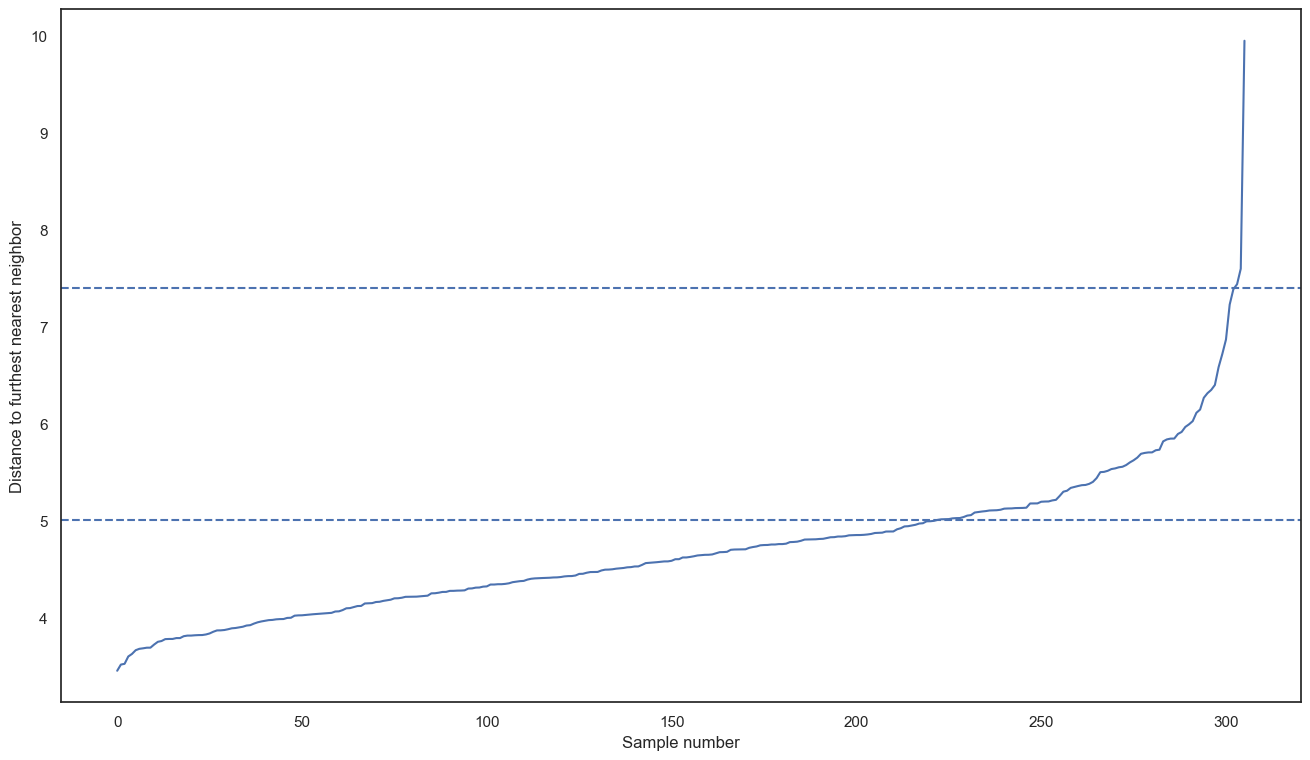

In [57]:
microsat_after_pca = gdf.drop(['Longitude', 'Latitude','geometry'], axis=1)
najblizszychsasiadow(microsat_after_pca,25,5,7.4)

In [58]:
evaluate_silhouette_score(microsat_after_pca,np.arange(4,8,0.01), range(14,20,1))

Best silhouette score: 0.4485478608703836
min_samples: 14
eps: 5.629999999999965


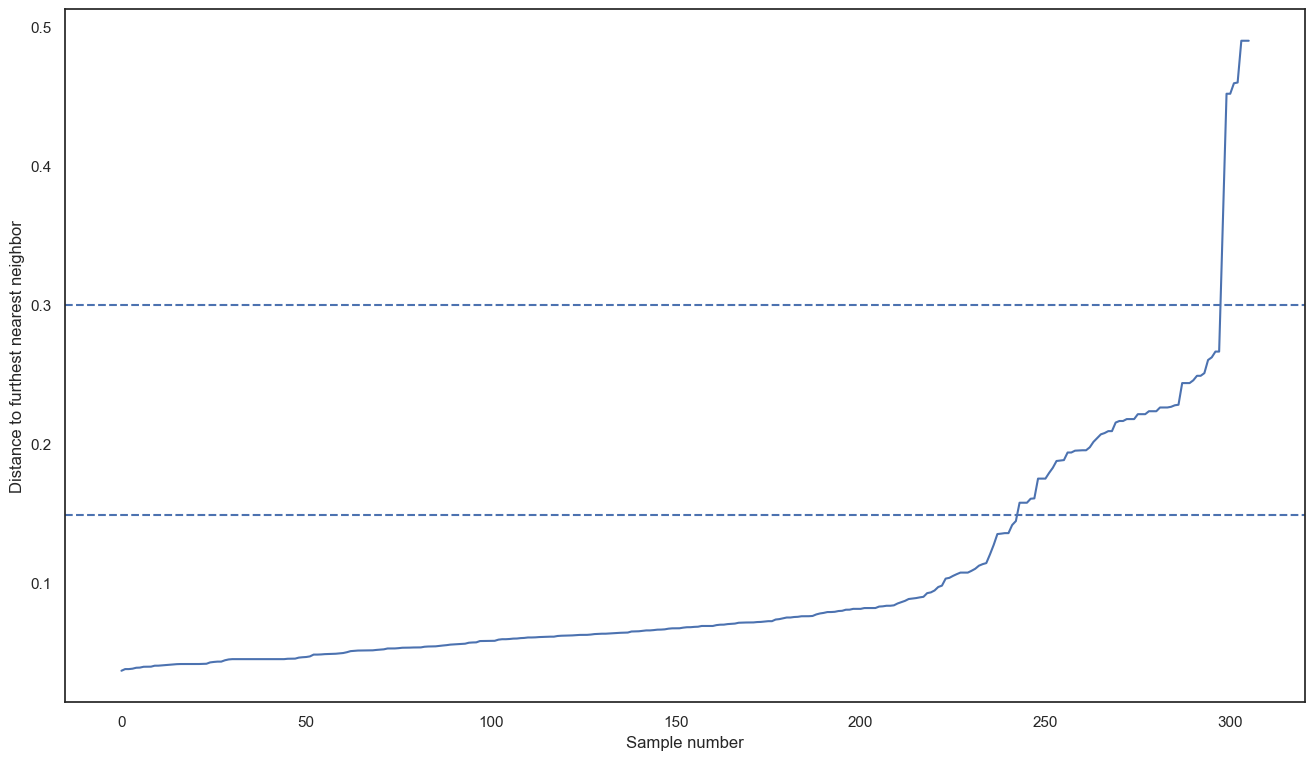

In [59]:
wspolrzedne = gdf[['Longitude', 'Latitude']]
najblizszychsasiadow(wspolrzedne,25,0.149,0.3) #np.arange(0, 1.3, 0.05)

In [60]:
evaluate_silhouette_score(wspolrzedne,np.arange(0.08,0.56,0.01), range(3,10,1))

Best silhouette score: 0.5487106913044187
min_samples: 6
eps: 0.14999999999999997


In [61]:
wspolrzedne = wspolrzedne.to_numpy()

Liczba clusters: 2


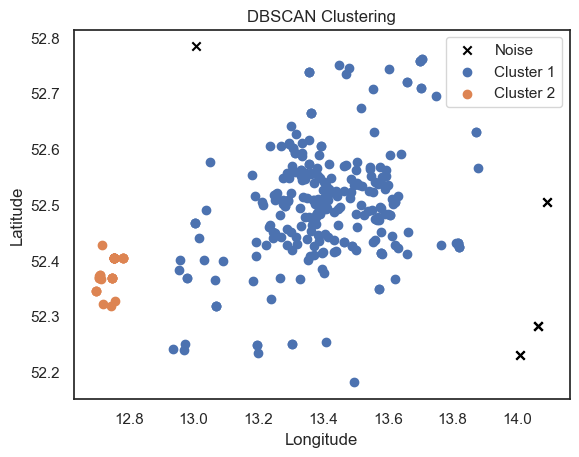

In [62]:
dbscan(wspolrzedne, 0.14999, 6)

Liczba clusters: 1


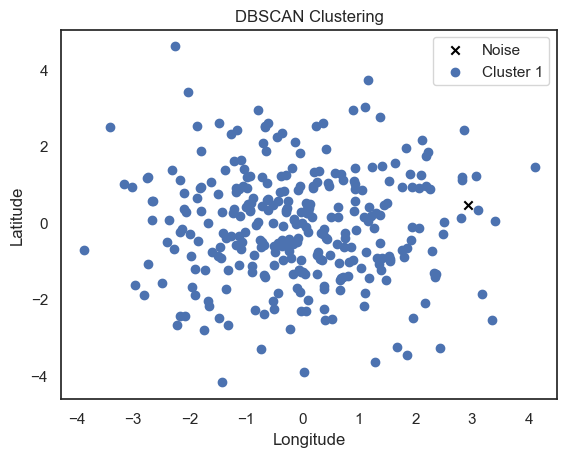

In [433]:
microsat_after_pca = microsat_after_pca.to_numpy()
dbscan(microsat_after_pca, 5.6299, 14)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of

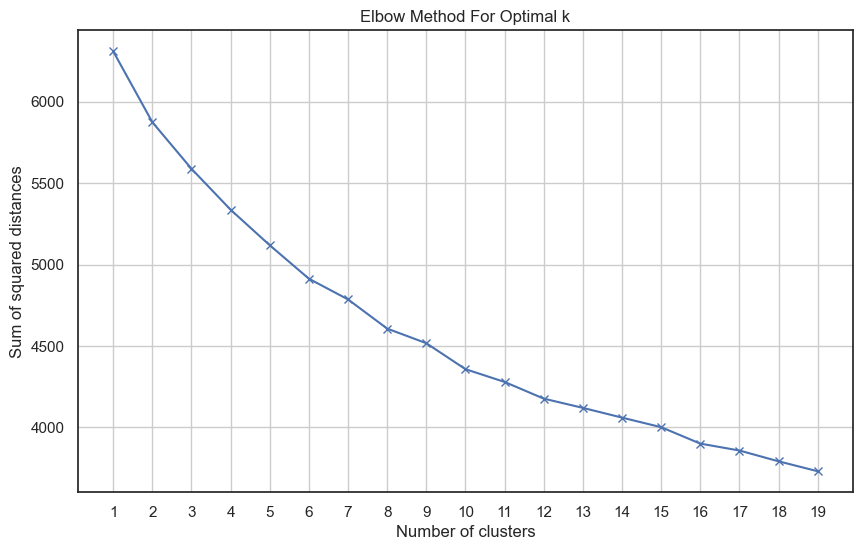

In [63]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(microsat_after_pca)
    sse[k] = kmeans.inertia_  


plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of

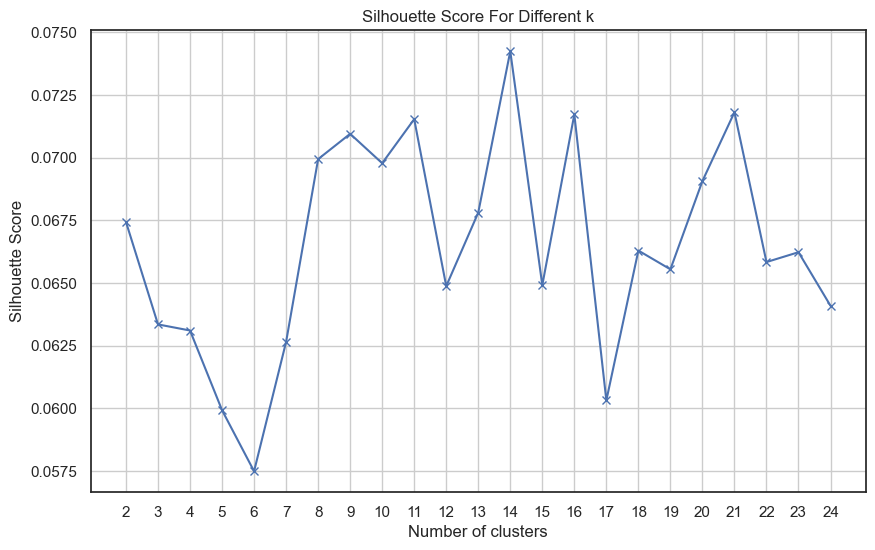

{2: 0.06743466386435912,
 3: 0.06334795500688908,
 4: 0.06310457134047827,
 5: 0.05992652632963332,
 6: 0.057491770333783096,
 7: 0.06265039931965204,
 8: 0.06993964101865088,
 9: 0.07094850106699599,
 10: 0.0697764151777964,
 11: 0.07153272193751282,
 12: 0.06487442158901119,
 13: 0.06780657309125322,
 14: 0.07424178769262678,
 15: 0.06491389327923296,
 16: 0.07172226719386403,
 17: 0.06031697800248778,
 18: 0.06629317765177145,
 19: 0.06554452414759365,
 20: 0.06906550190670814,
 21: 0.07180924834615182,
 22: 0.06583447418679908,
 23: 0.06622695562405005,
 24: 0.06408979144155973}

In [64]:
from sklearn.metrics import silhouette_score


silhouette_scores = {}
for k in range(2, 25):  
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(microsat_after_pca)
    score = silhouette_score(microsat_after_pca, kmeans.labels_)
    silhouette_scores[k] = score


plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Different k')
plt.xticks(range(2, 25))
plt.grid(True)
plt.show()

silhouette_scores

In [71]:
gdf_kopia=gdf.copy()
kmeans_final = KMeans(n_clusters=14, max_iter=1000).fit(microsat_after_pca)

gdf_kopia['Cluster'] = kmeans_final.labels_
cluster_distribution = gdf_kopia['Cluster'].value_counts().sort_index()
cluster_distribution

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster
0     21
1     22
2     11
3     32
4     25
5     22
6     25
7     21
8      8
9     27
10    31
11    29
12    15
13    17
Name: count, dtype: int64

In [72]:
import plotly.express as px
fig = px.scatter_mapbox(gdf_kopia,
                     lat='Latitude',
                     lon='Longitude',
                     color='Cluster',zoom=3)


fig.update_layout(mapbox_style='carto-positron',
                    margin={'r': 10, 't': 10, 'l': 10, 'b': 10})
fig.show()

In [73]:
from sklearn.cluster import SpectralClustering


spectral_clust = SpectralClustering(n_clusters=14, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42) #9,14, 21
gdf_kopia['SpectralCluster'] = spectral_clust.fit_predict(microsat_after_pca)


spectral_cluster_distribution = gdf_kopia['SpectralCluster'].value_counts().sort_index()
spectral_cluster_distribution


SpectralCluster
0     10
1     38
2     20
3     24
4     34
5     16
6     18
7     30
8     18
9     25
10    12
11    24
12    18
13    19
Name: count, dtype: int64

In [70]:
import plotly.express as px
fig = px.scatter_mapbox(gdf_kopia,
                     lat='Latitude',
                     lon='Longitude',
                     color='SpectralCluster',zoom=3)


fig.update_layout(mapbox_style='carto-positron',
                    margin={'r': 10, 't': 10, 'l': 10, 'b': 10})
fig.show()